In [1]:
# import all the necessary pacakges
import shap
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import pickle
import joblib

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV


from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.pipeline import Pipeline

from sklearn.inspection import permutation_importance
from sklearn.inspection import plot_partial_dependence
from sklearn.compose import ColumnTransformer

from category_encoders.leave_one_out import LeaveOneOutEncoder

from xgboost import XGBClassifier
from xgboost import plot_importance

from imblearn.over_sampling import SMOTE


import keras
from keras.layers import *
from keras.models import *
from keras.layers.embeddings import Embedding

from collections import Counter
from prettytable import PrettyTable
import warnings

np.seterr(divide='ignore', invalid='ignore')
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# read the data
df = pd.read_pickle('../data/soft_impute_final.pickle')

In [3]:
df.head()

,Var6,Var7,Var13,Var21,Var24,Var25,Var28,Var35,Var38,Var44,...,nan_Var218,nan_Var219,nan_Var221,nan_Var223,nan_Var226,nan_Var227,nan_Var228,Appetency,Churn,Upselling
0,1526.000000,7.0,184.0,464.000000,14.000000,128.0,166.56,0.0,3570.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1,-1
1,525.000000,0.0,0.0,168.000000,2.000000,24.0,353.52,0.0,4764966.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,1,-1
2,5236.000000,7.0,904.0,1212.000000,26.000000,816.0,220.08,0.0,5883894.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1,-1
3,69.125019,0.0,0.0,13.556917,0.361196,0.0,22.08,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1,-1
4,1029.000000,7.0,3216.0,64.000000,4.000000,64.0,200.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1,-1


**Frequency encoding**:
It is a way to utilize the frequency of the categories as labels.
In the cases where the frequency is related somewhat with the target variable,
it helps the model to understand and assign the weight in direct and inverse proportion,
depending on the nature of the data.

In [4]:
# Encoding functions
# we use the method of the winning KDD Cup 2009 to create binary variables for the top 10 categories

def encode_topcat_binary(X):
    categorical_ix = X.select_dtypes(include=['category','object', 'bool']).columns
    for cat in categorical_ix:
        processed_cat = [x for x in X[cat].value_counts().sort_values(ascending=False).head(10).index]
        for i in processed_cat:
            X[cat+'_'+i] = np.where(X[cat] == i, 1, 0) 
    return X

def encode_freq(X):
    # Code Reference : https://www.kaggle.com/bhavikapanara/frequency-encoding
    freq_encodings = dict()
    categorical_ix = X.select_dtypes(include=['category','object', 'bool']).columns
    for i in X[categorical_ix]:
        group = (X.groupby(i).size()) / len(X)
        X[i +'_freq'] = X[i].map(group)
        X[i +'_freq'] = X[i +'_freq'].astype(float)
        freq_encodings.update(dict(zip(group.index.values,group.values)))
        X = X.drop(i, axis=1)
    return X

In [5]:
# convert target values to binary
df_model = df.copy()

targets = ['Appetency', 'Churn', 'Upselling']

for col in targets:
    df_model[col] = df_model[col].apply(lambda x: 1 if x==1 else 0)
df_model[['Appetency', 'Churn', 'Upselling']].head()

,Appetency,Churn,Upselling
0,0,0,0
1,0,1,0
2,0,0,0
3,0,0,0
4,0,0,0


In [6]:
# Separate predictors and response
X = df_model.drop(columns=targets)

y_churn = df_model.Churn
y_appetency = df_model.Appetency
y_upselling = df_model.Upselling

X.shape, y_churn.shape

((50000, 120), (50000,))

In [7]:
# split datasets into X_train and y_train
X_train_churn, X_test_churn, y_train_churn, y_test_churn = train_test_split(X, y_churn, test_size = 0.2,random_state=42 )
X_train_appetency, X_test_appetency, y_train_appetency, y_test_appetency = train_test_split(X, y_appetency, test_size = 0.2,random_state=42 )
X_train_upselling, X_test_upselling, y_train_upselling, y_test_upselling = train_test_split(X, y_upselling, test_size = 0.2,random_state=42 )

In [8]:
# split the training data into train and validation sets. 
X_train_churn, X_val_churn, y_train_churn, y_val_churn = train_test_split(X_train_churn, y_train_churn, test_size = 0.2,random_state=42, stratify=y_train_churn)
X_train_appetency, X_val_appetency, y_train_appetency, y_val_appetency = train_test_split(X_train_appetency, y_train_appetency, test_size = 0.2,random_state=42, stratify=y_train_appetency)
X_train_upselling, X_val_upselling, y_train_upselling, y_val_upselling = train_test_split(X_train_upselling, y_train_upselling, test_size = 0.2,random_state=42, stratify=y_train_upselling)

## Class Weighted XGBoost

In [9]:
# computing the weights for each of the diffeent targets
# scale_pos_weight = total_neg_samples/total_pos_samples

#churn data
counter_churn = Counter(y_churn)
estimate_churn = counter_churn[0]/counter_churn[1]

#appetency data
counter_appetency = Counter(y_appetency)
estimate_appetency = counter_churn[0]/counter_appetency[1]

#upselling data
counter_upselling = Counter(y_upselling)
estimate_upselling = counter_upselling[0]/counter_upselling[1]

estimate_churn , estimate_appetency , estimate_upselling 

(12.616557734204793, 52.05393258426966, 12.579576317218903)

In [10]:
# encoding the categorical variables using topcat encoding and frequency encoding(see preprocessing
# notebook for more)

# for churn data
X_enct_churn = encode_topcat_binary(X_train_churn)
X_enc_train_churn = encode_freq(X_enct_churn)

X_encv_churn = encode_topcat_binary(X_val_churn)
X_enc_val_churn = encode_freq(X_encv_churn)

#for appetency data
X_enct_appetency = encode_topcat_binary(X_train_appetency)
X_enc_train_appetency = encode_freq(X_enct_appetency)

X_encv_appetency = encode_topcat_binary(X_val_appetency)
X_enc_val_appetency = encode_freq(X_encv_appetency)

#for upselling data
X_enct_upselling = encode_topcat_binary(X_train_upselling)
X_enc_train_upselling = encode_freq(X_enct_upselling)

X_encv_upselling = encode_topcat_binary(X_val_upselling)
X_enc_val_upselling = encode_freq(X_encv_upselling)

### Understanding the parameters used:
Can be found in the xgboost documentation

hist tree method: An approximation tree method used in LightGBM with slight differences in implementation. It runs sketching before training using only user provided weights instead of hessian. The subsequent per-node histogram is built upon this global sketch. This is the fastest algorithm as it runs sketching only once. 

scale_pos_weight: Control the balance of positive and negative weights, useful for unbalanced classes.

In [11]:
pipe = Pipeline(steps=[('xgb', XGBClassifier(objective='binary:logistic', tree_method='hist',
                                            scale_pos_weight=estimate_upselling))],
              verbose=False)

params = {
        'xgb__learning_rate': [0.05, 0.025 ,0.01, 0.1],
        'xgb__max_depth': [2, 4, 8, 10, 12],
        'xgb__n_estimators': [ 10, 25, 100,200],
        'xgb__gamma': [0,5,10]
        }

fit_params={
    "xgb__eval_set":[(X_enc_train_upselling.to_numpy(), y_train_upselling.to_numpy()), 
                     (X_enc_val_upselling.to_numpy(), y_val_upselling.to_numpy())
                    ],
    "xgb__eval_metric": 'auc',
    "xgb__early_stopping_rounds":50,
    "xgb__verbose":False
}

stratified_kfold = StratifiedKFold(n_splits=10,
                                       shuffle=True,
                                       random_state=42)

clf = RandomizedSearchCV(pipe, param_distributions=params, scoring='roc_auc', n_jobs=-1, cv=stratified_kfold)
clf.fit(X_enc_train_upselling.to_numpy(), y_train_upselling.to_numpy(), **fit_params) #need to convert to numpy array in order to fit params

best_xgb = clf.best_estimator_
print(clf.best_score_)
print(clf.best_params_)
print(best_xgb)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


0.8637855217759581
{'xgb__n_estimators': 100, 'xgb__max_depth': 4, 'xgb__learning_rate': 0.05, 'xgb__gamma': 5}
Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=5, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.05,
                               max_delta_step=0, max_depth=4,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=16, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=12.579576317218903, subsample=1,
                               tree_method='hist', validate_parameters=1,
                            

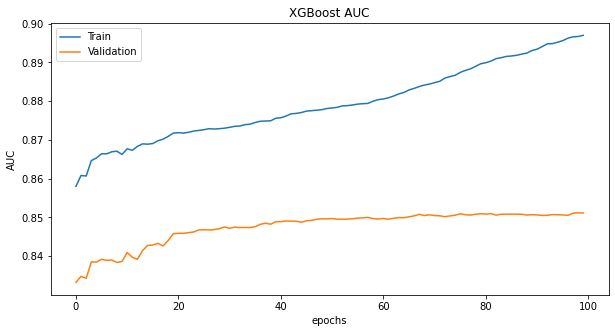

In [12]:
# retrieve performance metrics
results = clf.best_estimator_.named_steps["xgb"].evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)
# plot auc score
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Validation')
ax.legend()
plt.ylabel('AUC')
plt.xlabel('epochs')
plt.title('XGBoost AUC')
plt.show()

In [11]:
#joblib.dump(best_xgb,"xgb_upselling.pkl") # saving model as a pickle file
model_upselling = joblib.load("../models/xgb/xgb_upselling.pkl")
model_churn = joblib.load("../models/xgb/xgb_churn.pkl")
model_appetency = joblib.load("../models/xgb/xgb_appetency.pkl")

In [12]:
print('Validation Data - Churn Target :')
churn_auc = roc_auc_score(y_val_churn, model_churn.predict_proba(X_enc_val_churn)[:,1])
print(classification_report(y_val_churn.to_numpy(), model_churn.predict(X_enc_val_churn.to_numpy())))
print(confusion_matrix(y_val_churn.to_numpy(), model_churn.predict(X_enc_val_churn.to_numpy())))
print(roc_auc_score(y_val_churn, model_churn.predict_proba(X_enc_val_churn)[:,1]))

Validation Data - Churn Target :
              precision    recall  f1-score   support

           0       0.96      0.70      0.81      7405
           1       0.14      0.63      0.24       595

    accuracy                           0.70      8000
   macro avg       0.55      0.66      0.52      8000
weighted avg       0.90      0.70      0.77      8000

[[5200 2205]
 [ 222  373]]
0.7343132904748665


In [13]:
print('Validation Data - Upselling Target :')
upselling_auc = roc_auc_score(y_val_upselling, model_upselling.predict_proba(X_enc_val_upselling)[:,1])
print(classification_report(y_val_upselling.to_numpy(), model_upselling.predict(X_enc_val_upselling.to_numpy())))
print(confusion_matrix(y_val_upselling.to_numpy(), model_upselling.predict(X_enc_val_upselling.to_numpy())))
print(roc_auc_score(y_val_upselling, model_upselling.predict_proba(X_enc_val_upselling)[:,1]))

Validation Data - Upselling Target :
              precision    recall  f1-score   support

           0       0.97      0.85      0.90      7417
           1       0.25      0.63      0.35       583

    accuracy                           0.83      8000
   macro avg       0.61      0.74      0.63      8000
weighted avg       0.91      0.83      0.86      8000

[[6280 1137]
 [ 214  369]]
0.8493223231318531


In [14]:
print('Validation Data - Appetency Target :')
appetency_auc = roc_auc_score(y_val_appetency, model_appetency.predict_proba(X_enc_val_appetency)[:,1])
print(classification_report(y_val_appetency.to_numpy(), model_appetency.predict(X_enc_val_appetency.to_numpy())))
print(confusion_matrix(y_val_appetency.to_numpy(), model_appetency.predict(X_enc_val_appetency.to_numpy())))
print(roc_auc_score(y_val_appetency, model_appetency.predict_proba(X_enc_val_appetency)[:,1]))

Validation Data - Appetency Target :
              precision    recall  f1-score   support

           0       0.99      0.73      0.84      7855
           1       0.05      0.80      0.10       145

    accuracy                           0.73      8000
   macro avg       0.52      0.77      0.47      8000
weighted avg       0.98      0.73      0.83      8000

[[5750 2105]
 [  29  116]]
0.8260453477907768


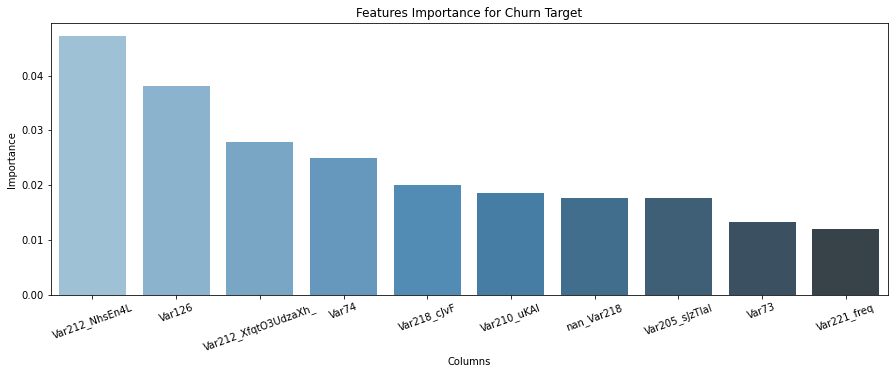

In [19]:
indices = np.argsort(model_churn.named_steps["xgb"].feature_importances_)[::-1] #default is 'gain'

features = []
for i in range(10):
    features.append(X_enc_val_churn.columns[indices[i]])

fig, ax = plt.subplots(figsize=(15,5))     

import seaborn as sns
sns.barplot(x=features, y= model_churn.named_steps["xgb"].feature_importances_[indices[range(10)]],\
label="Important Features", palette=("Blues_d"),ax=ax).\
set_title('Features Importance for Churn Target')

ax.set(xlabel="Columns", ylabel = "Importance")
plt.xticks(rotation=20)
plt.show()

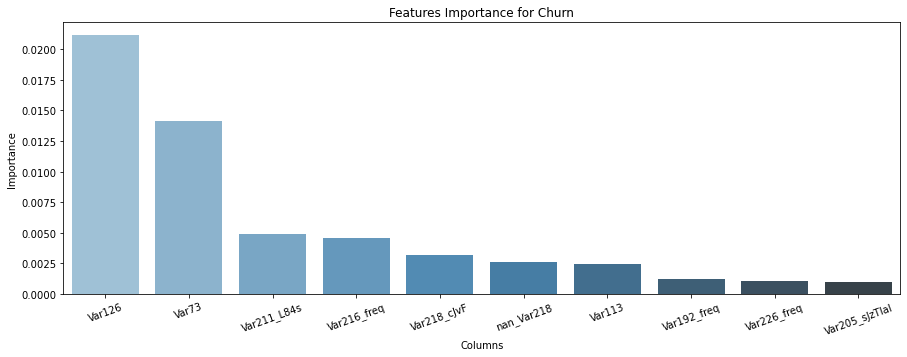

In [20]:
#This permutation method will randomly shuffle each feature and compute the change in the model’s performance. 
#The features which impact the performance the most are the most important one.
perm_importance = permutation_importance(model_churn, X_enc_val_churn.values, y_val_churn.values)
sorted_idx = perm_importance.importances_mean.argsort()[::-1]

features = []
for i in range(10):
    features.append(X_enc_val_churn.columns[sorted_idx[i]])

fig, ax = plt.subplots(figsize=(15,5))     

import seaborn as sns
sns.barplot(x=features, y= perm_importance.importances_mean[sorted_idx[range(10)]],\
label="Important Features", palette=("Blues_d"),ax=ax).\
set_title('Features Importance for Churn')

ax.set(xlabel="Columns", ylabel = "Importance")
plt.xticks(rotation=20)
plt.show()

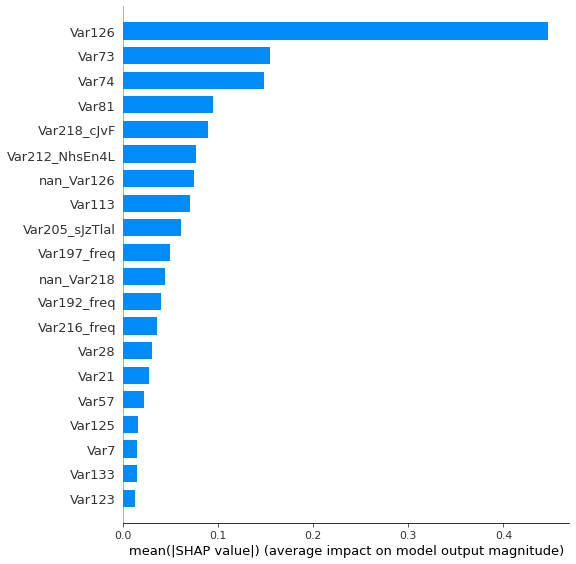

In [21]:
#It is model-agnostic and using the Shapley values from game theory to estimate the how does each feature 
#contribute to the prediction.
explainer = shap.TreeExplainer(model_churn.named_steps["xgb"])
shap_values = explainer.shap_values(X_enc_val_churn)
shap.summary_plot(shap_values, X_enc_val_churn, plot_type="bar")

There are differences in all the above feature importances because of how they are computed. But it is reassuring to see that some of the features are the same. A reason for this difference can also arise from the collinearity between features that wasnt fully taken care of.

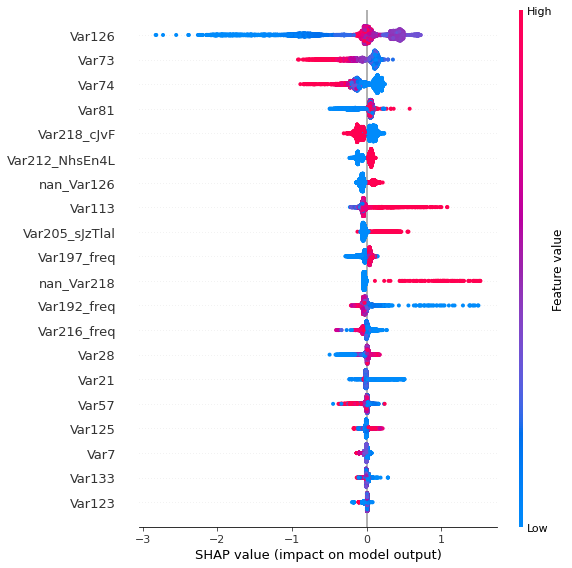

In [22]:
shap.summary_plot(shap_values, X_enc_val_churn)

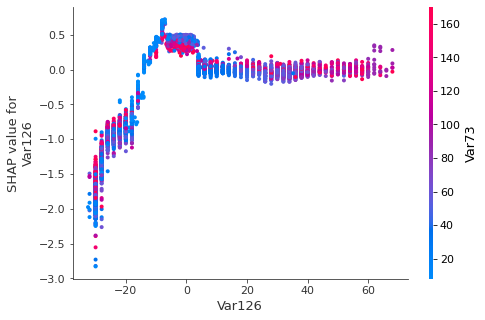

In [23]:
shap.dependence_plot("Var126", shap_values, X_enc_val_churn)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


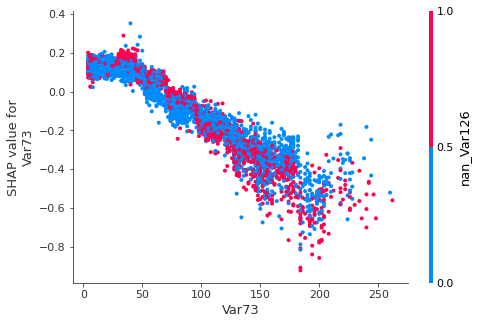

In [24]:
shap.dependence_plot("Var73", shap_values, X_enc_val_churn)

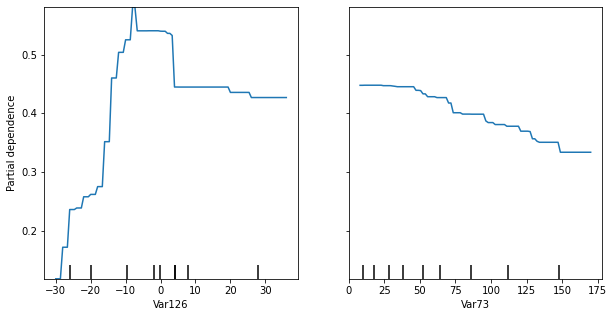

In [34]:
fig, ax = plt.subplots(figsize=(10,5)) 
plot_partial_dependence(model_churn.named_steps["xgb"], X_enc_val_churn, features = ['Var126', 'Var73'], ax=ax) 
plt.show()

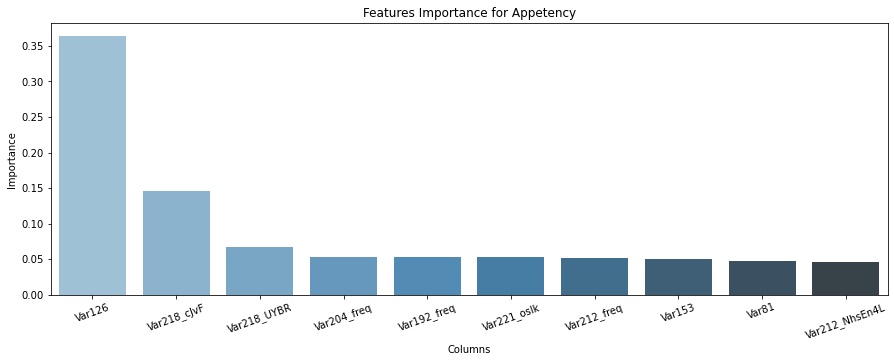

In [26]:
indices = np.argsort(model_appetency.named_steps["xgb"].feature_importances_)[::-1] #default is 'gain'

features = []
for i in range(10):
    features.append(X_enc_val_appetency.columns[indices[i]])

fig, ax = plt.subplots(figsize=(15,5))     

import seaborn as sns
sns.barplot(x=features, y= model_appetency.named_steps["xgb"].feature_importances_[indices[range(10)]],\
label="Important Features", palette=("Blues_d"),ax=ax).\
set_title('Features Importance for Appetency')

ax.set(xlabel="Columns", ylabel = "Importance")
plt.xticks(rotation=20)
plt.show()

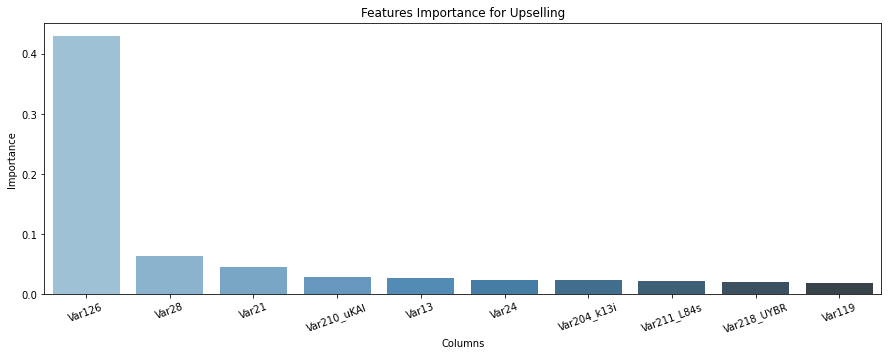

In [27]:
indices = np.argsort(model_upselling.named_steps["xgb"].feature_importances_)[::-1] #default is 'gain'

features = []
for i in range(10):
    features.append(X_enc_val_upselling.columns[indices[i]])

fig, ax = plt.subplots(figsize=(15,5))     

import seaborn as sns
sns.barplot(x=features, y= model_upselling.named_steps["xgb"].feature_importances_[indices[range(10)]],\
label="Important Features", palette=("Blues_d"),ax=ax).\
set_title('Features Importance for Upselling')

ax.set(xlabel="Columns", ylabel = "Importance")
plt.xticks(rotation=20)
plt.show()

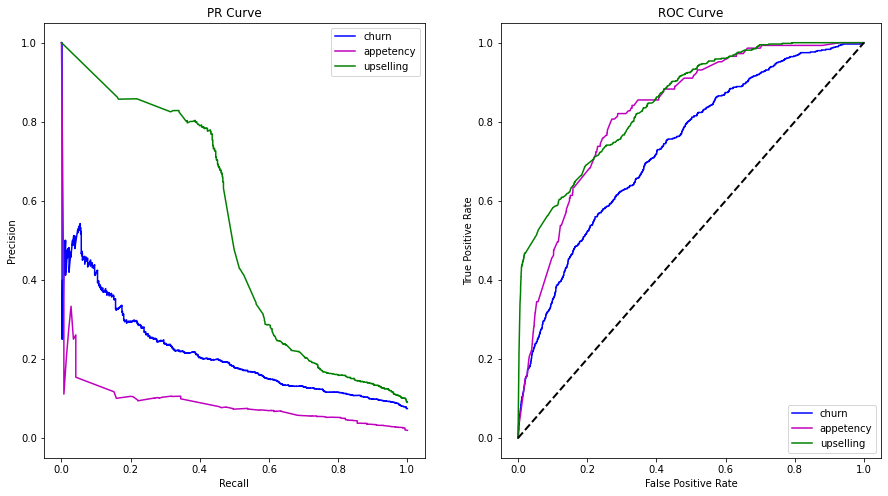

In [45]:
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')

for i,j,k,l,m in zip([model_churn, model_appetency, model_upselling],
                   [X_enc_val_churn,X_enc_val_appetency,X_enc_val_upselling ],
                   [y_val_churn, y_val_appetency, y_val_upselling],'bmg',
                    ['churn', 'appetency', 'upselling']):
    pred_prob = i.predict_proba(j)[:,1]

    p,r,_ = precision_recall_curve(k,pred_prob)
    tpr,fpr,_ = roc_curve(k,pred_prob)
    
    ax1.plot(r,p,c=l,label=m)
    ax2.plot(tpr,fpr,c=l,label=m)
ax1.legend(loc='upper right')    
ax2.legend(loc='lower right')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Random guess')

plt.show()

In [37]:
target_aucs = [appetency_auc, churn_auc, upselling_auc]
summary = PrettyTable()
summary.field_names = ["Data","AUC score","Average AUC score"]
summary.add_row(["Appetency",appetency_auc," "])
summary.add_row(["Churn",churn_auc,np.average(target_aucs)])
summary.add_row(["Upsell",upselling_auc," "])
print(summary)

+-----------+--------------------+--------------------+
|    Data   |     AUC score      | Average AUC score  |
+-----------+--------------------+--------------------+
| Appetency | 0.8260453477907768 |                    |
|   Churn   | 0.7329285799397409 | 0.8027654169541236 |
|   Upsell  | 0.8493223231318531 |                    |
+-----------+--------------------+--------------------+


## Gradient Boosting Classifier

### Using Churn as a response

In [15]:
# split datasets into X_train and y_train
X_train, X_test, y_train, y_test = train_test_split(X, y_churn, test_size = 0.2,random_state=42 )

In [16]:
# Encoding Categorical Data

#LeaveOneOutEncoder: Leave one out coding for categorical features.
# This is very similar to target encoding but excludes the current row’s target when calculating the mean target 
# for a level to reduce the effect of outliers.

#CatBoost: https://arxiv.org/abs/1706.09516
#Beware, the training data have to be randomly permutated. E.g.:

# Random permutation perm = np.random.permutation(len(X)) 
#X = X.iloc[perm].reset_index(drop=True) 
#y = y.iloc[perm].reset_index(drop=True)

numerical_ix = X.select_dtypes(include=['int64', 'float64']).columns
categorical_ix = X.select_dtypes(include=['category', 'bool']).columns

print('Numerical features :', len(numerical_ix)) 
print('Categorical features :', len(categorical_ix))

Numerical features : 98
Categorical features : 22


In [17]:
# create a transformer for the categorical values
# categorical_transformer = Pipeline(steps=[
#     ('encode_leaveoneout', LeaveOneOutEncoder(sigma=0.05))])

# create a transformer for the numerical values
# standardize the numerical data
over=SMOTE()

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_ix),
        # ('cat', categorical_transformer, categorical_ix)
    ])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('o',over),
                      ('classifier', GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features='log2', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=2, min_samples_split=2,

                           random_state=42))],
              verbose=False)

clf.fit(X_train, y_train)

In [18]:
# load the model
clf = joblib.load('../models/gradient_boost/gradient.pkl')
y_pred_train = clf.predict_proba(X_train)[:,-1]
y_pred_val_gnb = clf.predict_proba(X_test)[:,-1]
fpr_gnb, tpr_gnb, _ = roc_curve(y_test, y_pred_val_gnb)
y_predict_val = clf.predict(X_test)

c_test_auc = roc_auc_score(y_test, y_pred_val_gnb)
print("The ROC score for training set is:",np.round(roc_auc_score(y_train, y_pred_train), 3))
print("The ROC score for validation set is:",np.round(c_test_auc, 3))


The ROC score for training set is: 0.681
The ROC score for validation set is: 0.678


In [19]:
print(classification_report(y_test, y_predict_val))

              precision    recall  f1-score   support

           0       0.95      0.83      0.88      9305
           1       0.14      0.36      0.20       695

    accuracy                           0.80     10000
   macro avg       0.54      0.60      0.54     10000
weighted avg       0.89      0.80      0.84     10000



In [82]:
# compute permutation importance and plot
perm = permutation_importance(clf,
                             scoring='f1',X=X_test, y=y_test,n_repeats=20,random_state=0)
importance = perm.importances_mean

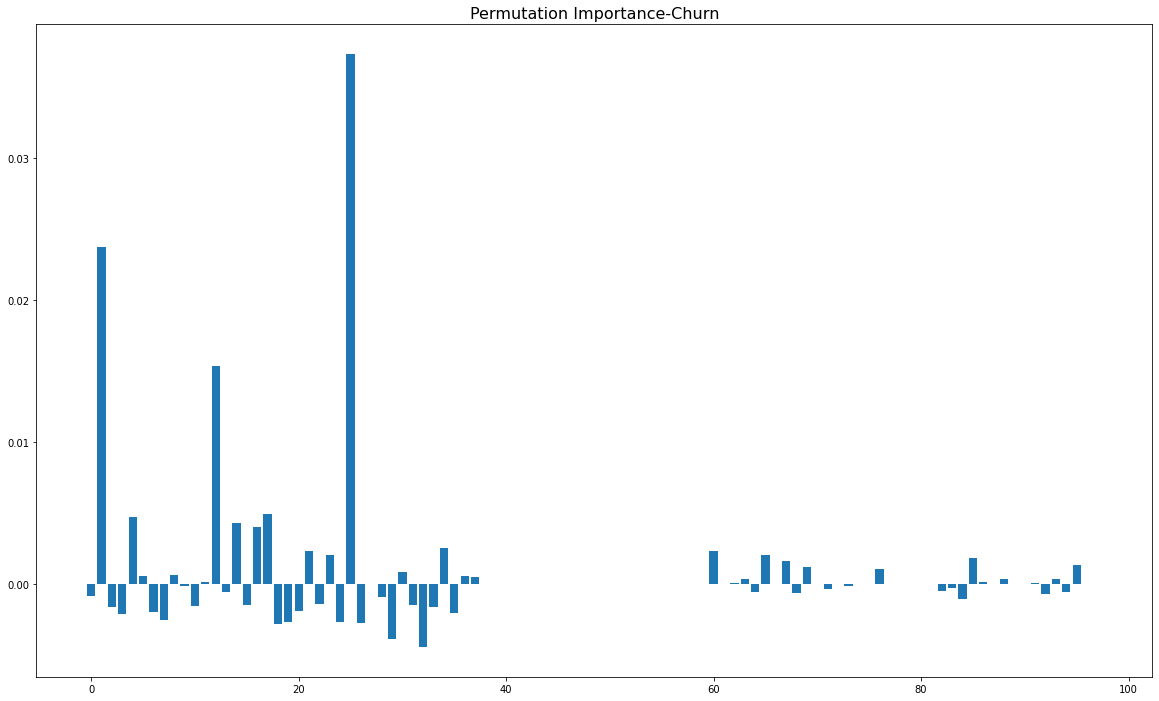

In [87]:
# plot feature importance
fig, axs = plt.subplots(1,figsize=(20,12))
axs.bar([x for x in range(98)], importance[:98])
axs.set_title('Permutation Importance-Churn', fontsize=16)
plt.show()

['Var149', 'Var140', 'Var85', 'Var132', 'Var125', 'Var109', 'Var35', 'Var21', 'Var163', 'Var28']


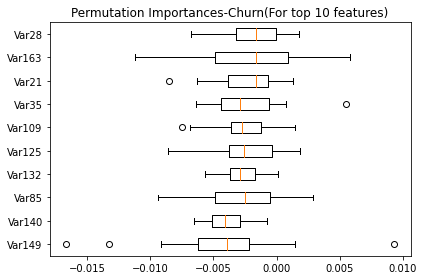

In [90]:
sorted_idx = perm.importances_mean.argsort()[:10]
top_features = []
for c in sorted_idx:
  top_features.append(X_train.columns[c])
print(top_features)

fig, ax = plt.subplots()
ax.boxplot(perm.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances-Churn(For top 10 features)")
fig.tight_layout()
plt.show()

### Using Appentency as a response

In [20]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y_appetency, test_size = 0.2,random_state=42 )

In [21]:
# create a transformer for the categorical values
# categorical_transformer = Pipeline(steps=[
#     ('encode_leaveoneout', LeaveOneOutEncoder(sigma=0.05))])

# create a transformed for the numerical values
# standardize the numerical data
over=SMOTE()
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_ix),
        # ('cat', categorical_transformer, categorical_ix)
    ])

clf1 = Pipeline(steps=[('preprocessor', preprocessor),
                      ('o',over),
                      ('classifier', GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features='log2', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=2, min_samples_split=2,

                           random_state=42))],
              verbose=False)

clf1.fit(X_train, y_train)

In [22]:
# load the model
clf1 = joblib.load('../models/gradient_boost/gradient_appetency.pkl')

y_pred_train = clf1.predict_proba(X_train)[:,-1]
y_pred_test_gnb = clf1.predict_proba(X_test)[:,-1]
fpr_gnb1, tpr_gnb, _ = roc_curve(y_test, y_pred_test_gnb)
y_predict_test = clf1.predict(X_test)

a_test_auc = roc_auc_score(y_test, y_pred_test_gnb)
print("The ROC score for training set is:",np.round(roc_auc_score(y_train, y_pred_train), 3))
print("The ROC score for validation set is:",np.round(a_test_auc, 3))
print("Confusion matrix for validation set:\n",confusion_matrix(y_test, y_predict_test))

The ROC score for training set is: 0.768
The ROC score for validation set is: 0.712
Confusion matrix for validation set:
 [[8056 1777]
 [  87   80]]


In [23]:
print(classification_report(y_test, y_predict_test))

              precision    recall  f1-score   support

           0       0.99      0.82      0.90      9833
           1       0.04      0.48      0.08       167

    accuracy                           0.81     10000
   macro avg       0.52      0.65      0.49     10000
weighted avg       0.97      0.81      0.88     10000



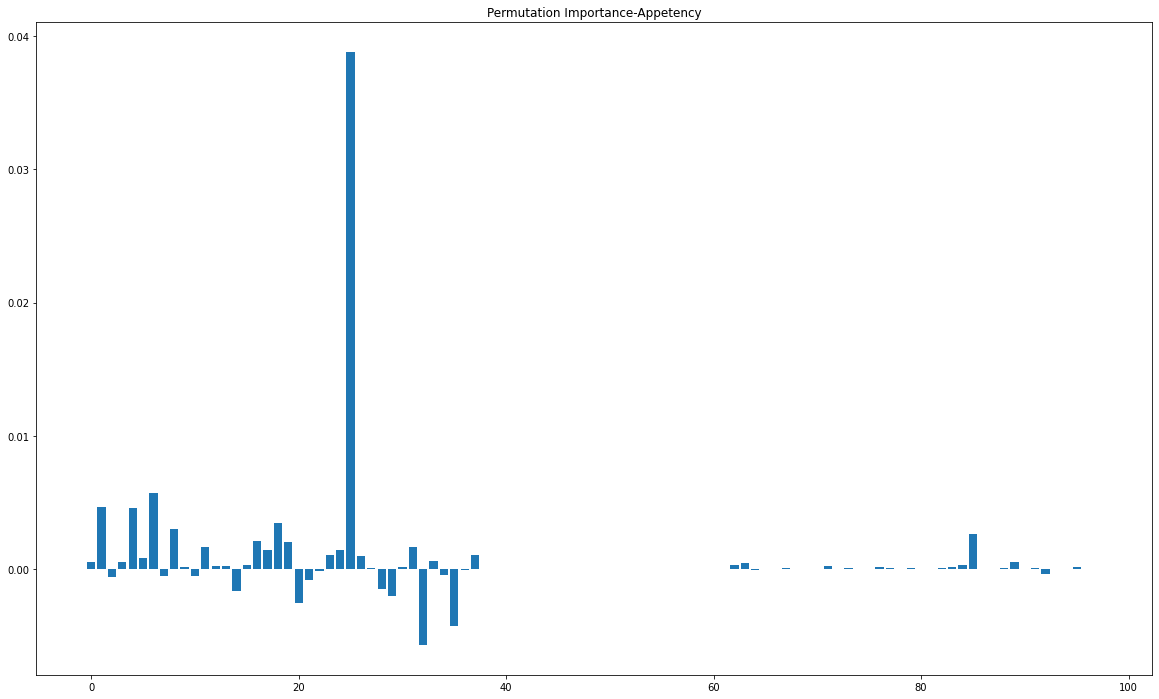

In [100]:
# compute permutation importances
perm1 = permutation_importance(clf1,
                             scoring='f1',X=X_test, y=y_test,n_repeats=20,random_state=0)
importance1 = perm1.importances_mean

# plot
fig, axs = plt.subplots(1,figsize=(20,12))
axs.bar([x for x in range(98)], importance1[:98])
axs.set_title('Permutation Importance-Appetency')
plt.show()

['Var149', 'Var163', 'Var112', 'Var140', 'Var76', 'Var134', 'Var113', 'nan_Var223', 'Var13', 'Var57']


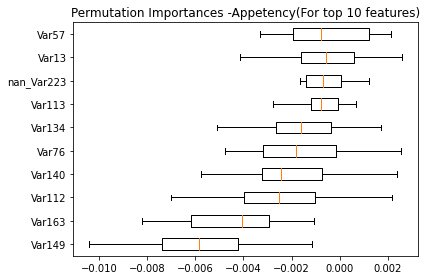

In [102]:
sorted_idx1 = perm1.importances_mean.argsort()[:10]
top_features1 = []
for c in sorted_idx1:
  top_features1.append(X_train.columns[c])
print(top_features1)

fig, ax = plt.subplots()
ax.boxplot(perm1.importances[sorted_idx1].T,
           vert=False, labels=X_test.columns[sorted_idx1])
ax.set_title("Permutation Importances -Appetency(For top 10 features)")
fig.tight_layout()
plt.show()

### Using Upselling as a response

In [24]:
# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y_upselling, test_size = 0.2,random_state=42 )

In [25]:
# create a transformer for the categorical values
# categorical_transformer = Pipeline(steps=[
#     ('encode_leaveoneout', LeaveOneOutEncoder(sigma=0.05))])

# create a transformed for the numerical values
# standardize the numerical data
over=SMOTE()
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_ix),
        # ('cat', categorical_transformer, categorical_ix)
    ])

clf2 = Pipeline(steps=[('preprocessor', preprocessor),
                      ('o',over),
                      ('classifier', GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features='log2', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=2, min_samples_split=2,

                           random_state=42))],
              verbose=False)

clf2.fit(X_train, y_train)

In [28]:
clf2 = joblib.load('../models/gradient_boost/gradient_upselling.pkl')
y_pred_train = clf2.predict_proba(X_train)[:,-1]
y_pred_test_gnb = clf2.predict_proba(X_test)[:,-1]
fpr_gnb1, tpr_gnb, _ = roc_curve(y_test, y_pred_test_gnb)
y_predict_test = clf2.predict(X_test)
u_test_auc = roc_auc_score(y_test, y_pred_test_gnb)
print("The ROC score for training set is:",np.round(roc_auc_score(y_train, y_pred_train), 3))
print("The ROC score for validation set is:",np.round(u_test_auc, 3))
print("Confusion matrix for validation set:\n",confusion_matrix(y_test, y_predict_test))

The ROC score for training set is: 0.842
The ROC score for validation set is: 0.819
Confusion matrix for validation set:
 [[8247  988]
 [ 333  432]]


In [29]:
print(classification_report(y_test, y_predict_test))

              precision    recall  f1-score   support

           0       0.96      0.89      0.93      9235
           1       0.30      0.56      0.40       765

    accuracy                           0.87     10000
   macro avg       0.63      0.73      0.66     10000
weighted avg       0.91      0.87      0.89     10000



Text(0.5, 1.0, 'Permutation Importance Upselling')

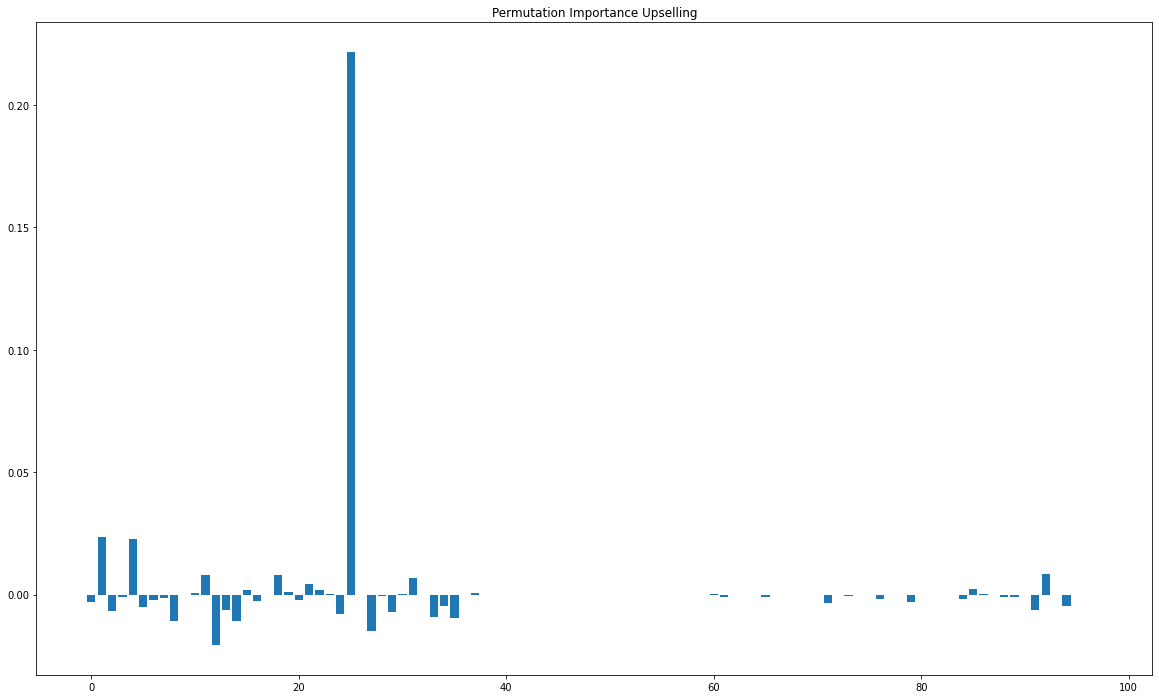

In [110]:
# calculate permutation importance
perm2 = permutation_importance(clf2,
                             scoring='f1',X=X_test, y=y_test,n_repeats=20,random_state=0)
importance2 = perm2.importances_mean

# plot
fig, axs = plt.subplots(1,figsize=(20,12))
axs.bar([x for x in range(98)], importance2[:98])
axs.set_title('Permutation Importance Upselling')

['Var73', 'Var133', 'Var76', 'Var38', 'Var163', 'Var153', 'Var125', 'Var140', 'Var13', 'Var74']


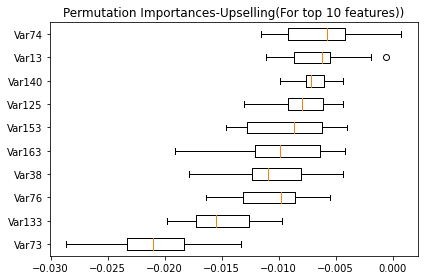

In [111]:
sorted_idx2 = perm2.importances_mean.argsort()[:10]
top_features2 = []
for c in sorted_idx2:
  top_features2.append(X_train.columns[c])
print(top_features2)

fig, ax = plt.subplots()
ax.boxplot(perm2.importances[sorted_idx2].T,
           vert=False, labels=X_test.columns[sorted_idx2])
ax.set_title("Permutation Importances-Upselling(For top 10 features))")
fig.tight_layout()
plt.show()

In [120]:
target_aucs = [a_test_auc, c_test_auc, u_test_auc]
from prettytable import PrettyTable
summary = PrettyTable()
summary.field_names = ["Data","AUC score","Average AUC score"]
summary.add_row(["Appetency",a_test_auc," "])
summary.add_row(["Churn",c_test_auc," "])
summary.add_row(["Upsell",u_test_auc,np.average(target_aucs)])
print(summary)

+-----------+--------------------+--------------------+
|    Data   |     AUC score      | Average AUC score  |
+-----------+--------------------+--------------------+
| Appetency | 0.7124122547135973 |                    |
|   Churn   | 0.6782208837980664 |                    |
|   Upsell  | 0.819188296867204  | 0.7366071451262893 |
+-----------+--------------------+--------------------+


In [121]:
X_train.shape

(40000, 120)

## Random Forest And Extra Tree Classifier

In [30]:
# create a copy of X dataframe
proxy = X.copy(deep=True)
y = y_churn
# encode using custom function
t = encode_topcat_binary(proxy)
t = t.select_dtypes(exclude=['category'])
t.head()

,Var6,Var7,Var13,Var21,Var24,Var25,Var28,Var35,Var38,Var44,...,Var228_F2FyR07IdsN7I,Var228_55YFVY9,Var228_ib5G6X1eUxUn6,Var228_R4y5gQQWY8OodqDV,Var228_xwM2aC7IdeMC0,Var228_TCU50_Yjmm6GIBZ0lL_,Var228_iyHGyLCEkQ,Var228_Zy3gnGM,Var228_F2FcTt7IdMT_v,Var228_SbOd7O8ky1wGNxp0Arj0Xs
0,1526.000000,7.0,184.0,464.000000,14.000000,128.0,166.56,0.0,3570.0,0.0,...,1,0,0,0,0,0,0,0,0,0
1,525.000000,0.0,0.0,168.000000,2.000000,24.0,353.52,0.0,4764966.0,0.0,...,1,0,0,0,0,0,0,0,0,0
2,5236.000000,7.0,904.0,1212.000000,26.000000,816.0,220.08,0.0,5883894.0,0.0,...,0,0,1,0,0,0,0,0,0,0
3,69.125019,0.0,0.0,13.556917,0.361196,0.0,22.08,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
4,1029.000000,7.0,3216.0,64.000000,4.000000,64.0,200.00,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0


In [31]:
# frequency encode using custom function
p = encode_freq(proxy)
p.head()

,Var6,Var7,Var13,Var21,Var24,Var25,Var28,Var35,Var38,Var44,...,Var211_freq,Var212_freq,Var216_freq,Var218_freq,Var219_freq,Var221_freq,Var223_freq,Var226_freq,Var227_freq,Var228_freq
0,1526.000000,7.0,184.0,464.000000,14.000000,128.0,166.56,0.0,3570.0,0.0,...,0.80598,0.12866,0.06154,0.50638,0.80608,0.74018,0.11990,0.04216,0.70312,0.65406
1,525.000000,0.0,0.0,168.000000,2.000000,24.0,353.52,0.0,4764966.0,0.0,...,0.80598,0.58606,0.02122,0.01406,0.80608,0.74018,0.73216,0.05228,0.70312,0.65406
2,5236.000000,7.0,904.0,1212.000000,26.000000,816.0,220.08,0.0,5883894.0,0.0,...,0.80598,0.01092,0.00004,0.47956,0.80608,0.03324,0.11990,0.09664,0.04684,0.05344
3,69.125019,0.0,0.0,13.556917,0.361196,0.0,22.08,0.0,0.0,0.0,...,0.19402,0.58606,0.00594,0.47956,0.80608,0.74018,0.73216,0.16062,0.70312,0.65406
4,1029.000000,7.0,3216.0,64.000000,4.000000,64.0,200.00,0.0,0.0,0.0,...,0.80598,0.12866,0.03576,0.47956,0.80608,0.74018,0.73216,0.16062,0.70312,0.65406


In [32]:
# create a func to split the data
def train_test_splitter(X,y):
    xtr, ytr, xte, yte = train_test_split(X,y,test_size=0.2, random_state=42)
    return xtr, ytr, xte, yte

In [33]:
# split datasets into X_train and y_train
X_train, X_test, y_train, y_test = train_test_splitter(t, y)

#split the train data into training and validation sets
Xtrain, Xval, ytrain, yval = train_test_splitter(X_train,y_train)

In [34]:
# instantiate smote for oversampling
over = SMOTE()

### Random Forest Classifier

In [35]:
create transformers and pipeline
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])
preprocessor = ColumnTransformer(
    transformers=[
        
        ('num', numeric_transformer, numerical_ix),
    ])

param = {'classifier__max_depth': [5,7], 
         'classifier__n_estimators':[50, 70, 100, 150], 
          'classifier__criterion' : ['gini', 'entropy'],
          'classifier__bootstrap':[True, False],
          'classifier__min_samples_leaf': [1,2,5]}

rf_clf = RandomForestClassifier( max_features='auto', 
                              
                                random_state=42,
                                class_weight='balanced_subsample')          

randomforestclf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('o',over),
                      ('classifier', rf_clf)],
              verbose=False)

search = RandomizedSearchCV(randomforestclf,param_distributions=param,scoring='accuracy',cv=5)
search.fit(Xtrain, ytrain)

In [37]:
# load the saved model
search = joblib.load('../models/rforest/rf_with_topcat.pickle')
y_pred_train = search.predict_proba(Xtrain)[:,-1]
y_pred_val_rf = search.predict_proba(Xval)[:,-1]
fpr_rf, tpr_rf, _ = roc_curve(yval, y_pred_val_rf)
y_predict_val_rf = search.predict(Xval)

print("The ROC score for training set is:",np.round(roc_auc_score(ytrain, y_pred_train), 3))
print("The ROC score for validation set is:",np.round(roc_auc_score(yval, y_pred_val_rf), 3))
print("Confusion matrix for validation set:\n",confusion_matrix(yval, y_predict_val_rf))

The ROC score for training set is: 0.726
The ROC score for validation set is: 0.69
Confusion matrix for validation set:
 [[5680 1704]
 [ 317  299]]


In [38]:
X_train2, X_test2, y_train2, y_test2 = train_test_splitter(p, y)
Xtrain2, Xval2, ytrain2, yval2 = train_test_splitter(X_train2,y_train2)

In [40]:
search12 = joblib.load('../models/rforest/rf_with_fenc.pickle')
y_pred_train_ = search12.predict_proba(Xtrain2)[:,-1]
y_pred_val_rf_ = search12.predict_proba(Xval2)[:,-1]
fpr_rf_, tpr_rf_, _ = roc_curve(yval2, y_pred_val_rf)
y_predict_val_rf_ = search12.predict(Xval2)

print("The ROC score for training set is:",np.round(roc_auc_score(ytrain2, y_pred_train_), 3))
print("The ROC score for validation set is:",np.round(roc_auc_score(yval2, y_pred_val_rf_), 3))
print("Confusion matrix for validation set:\n",confusion_matrix(yval2, y_predict_val_rf_))

The ROC score for training set is: 0.725
The ROC score for validation set is: 0.692
Confusion matrix for validation set:
 [[5626 1758]
 [ 309  307]]


Both top-categories encoding and frequency encoding gave similar results on the Random Forest model. We'll use only the top-categories-encoded data from here on out.

### Inference

In [41]:
y_pred_test_rf = search.predict(X_test)
print("The roc_auc_score of test data is:", np.round(roc_auc_score(y_test,y_pred_test_rf), 3))
print(classification_report(y_test, y_pred_test_rf))

The roc_auc_score of test data is: 0.613
              precision    recall  f1-score   support

           0       0.95      0.76      0.85      9305
           1       0.13      0.46      0.20       695

    accuracy                           0.74     10000
   macro avg       0.54      0.61      0.52     10000
weighted avg       0.89      0.74      0.80     10000



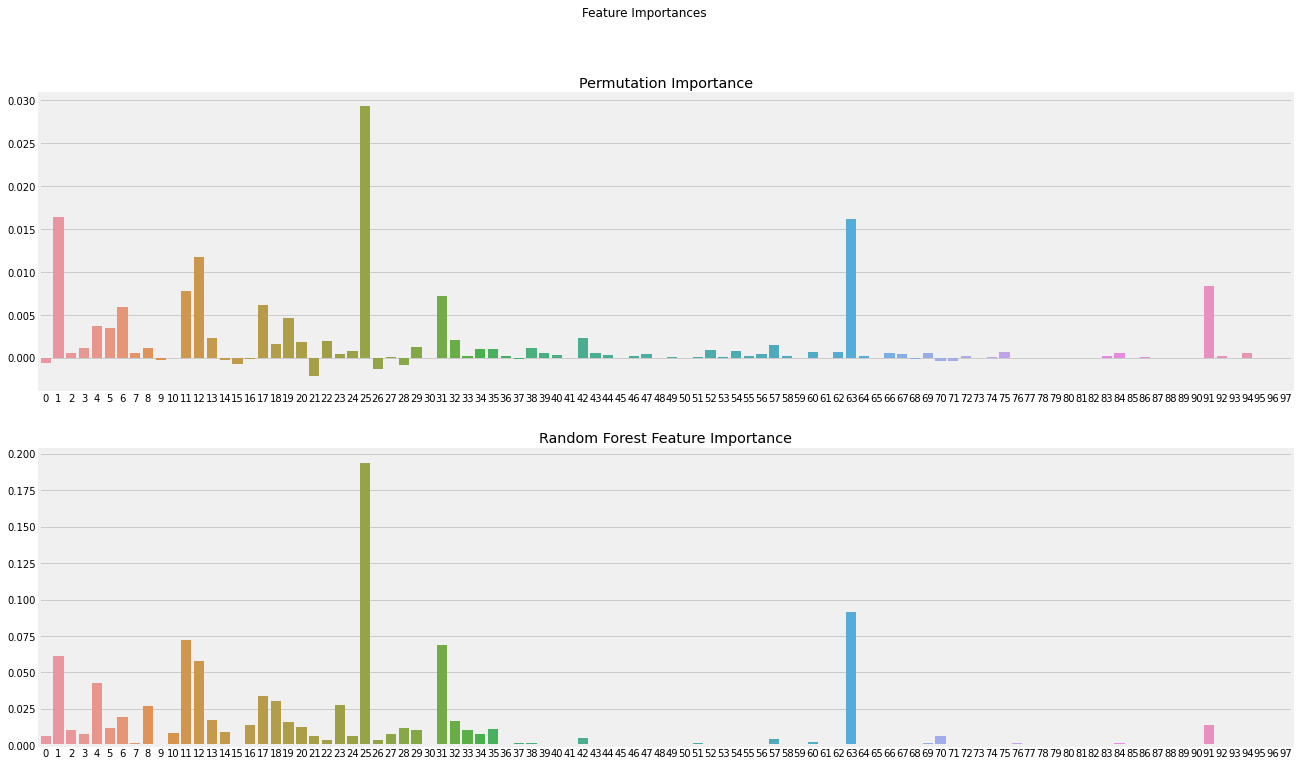

In [254]:
# compute permutation importance
perm = permutation_importance(search,
                             scoring='f1',X=Xval, y=yval,n_repeats=30,random_state=0)
importance = perm.importances_mean
imp = search.best_estimator_._final_estimator.feature_importances_

# plot permutation importances
fig, axs = plt.subplots(2,figsize=(20,12))
fig.suptitle('Feature Importances')
sns.barplot([x for x in range(98)], importance[:98],ax=axs[0])
axs[0].set_title('Permutation Importance')
sns.barplot([x for x in range(len(imp))], imp,ax=axs[1])
axs[1].set_title('Random Forest Feature Importance')
plt.show()

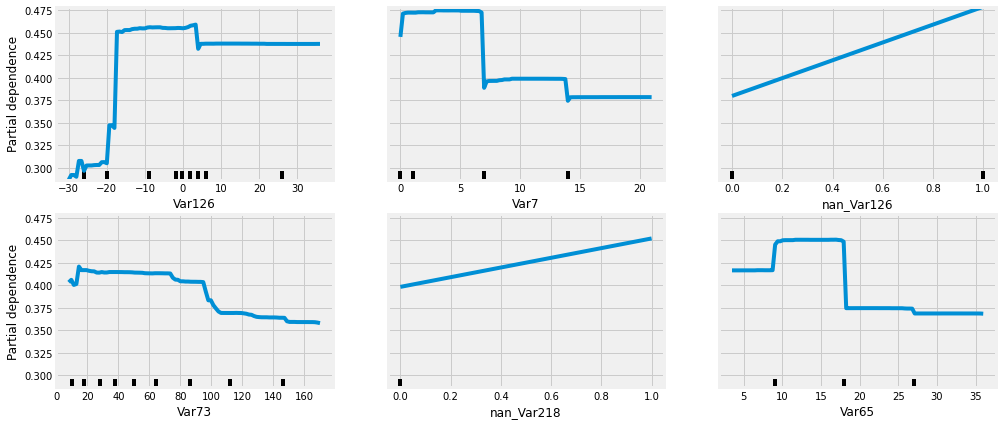

In [255]:
# get top features
top_vars = (-importance).argsort()[:6]
top_features = []
for c in top_vars:
  top_features.append(X_train.columns[c])

# plot partial dependence
fig, axes = plt.subplots(2, 3, figsize = (15, 7))
plot_partial_dependence(search.best_estimator_, Xval, top_features,ax=axes) 

### Extra Trees Classifier

In [42]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_ix),
        
    ])
xrf_clf = ExtraTreesClassifier(random_state=42,
                               bootstrap = True,
                               oob_score=True,
                               class_weight='balanced_subsample')

param = {'classifier__max_depth': [5,7], 
         'classifier__n_estimators':[50, 70, 100, 150, 250], 
          'classifier__min_samples_leaf': [1,2,5]}

xtreesclf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('o',over),
                      ('classifier', xrf_clf)],
              verbose=False)

search2 = RandomizedSearchCV(xtreesclf,param_distributions=param,scoring='accuracy',cv=5)
search2.fit(Xtrain, ytrain)

In [43]:
# load model
search2 = joblib.load('../models/rforest/xtrees_with_topcat.pickle')

y_pred_train = search2.predict_proba(Xtrain)[:,-1]
y_pred_val_xtr = search2.predict_proba(Xval)[:,-1]
fpr_xtr, tpr_xtr, _ = roc_curve(yval, y_pred_val_xtr)
y_predict_val_xtr = search2.predict(Xval)

print("The ROC score for training set is:",np.round(roc_auc_score(ytrain, y_pred_train), 3))
print("The ROC score for validation set is:",np.round(roc_auc_score(yval, y_pred_val_xtr), 3))
print("Confusion matrix for validation set:\n",confusion_matrix(yval, y_predict_val_xtr))

The ROC score for training set is: 0.701
The ROC score for validation set is: 0.703
Confusion matrix for validation set:
 [[4913 2471]
 [ 222  394]]


In [44]:
y_pred_test_xtr = search2.predict(X_test)
print("The roc_auc_score of test dtaa is:", roc_auc_score(y_test,y_pred_test_xtr))
print(classification_report(y_test, y_pred_test_xtr))

The roc_auc_score of test dtaa is: 0.6357512592827403
              precision    recall  f1-score   support

           0       0.96      0.66      0.78      9305
           1       0.12      0.61      0.20       695

    accuracy                           0.66     10000
   macro avg       0.54      0.64      0.49     10000
weighted avg       0.90      0.66      0.74     10000



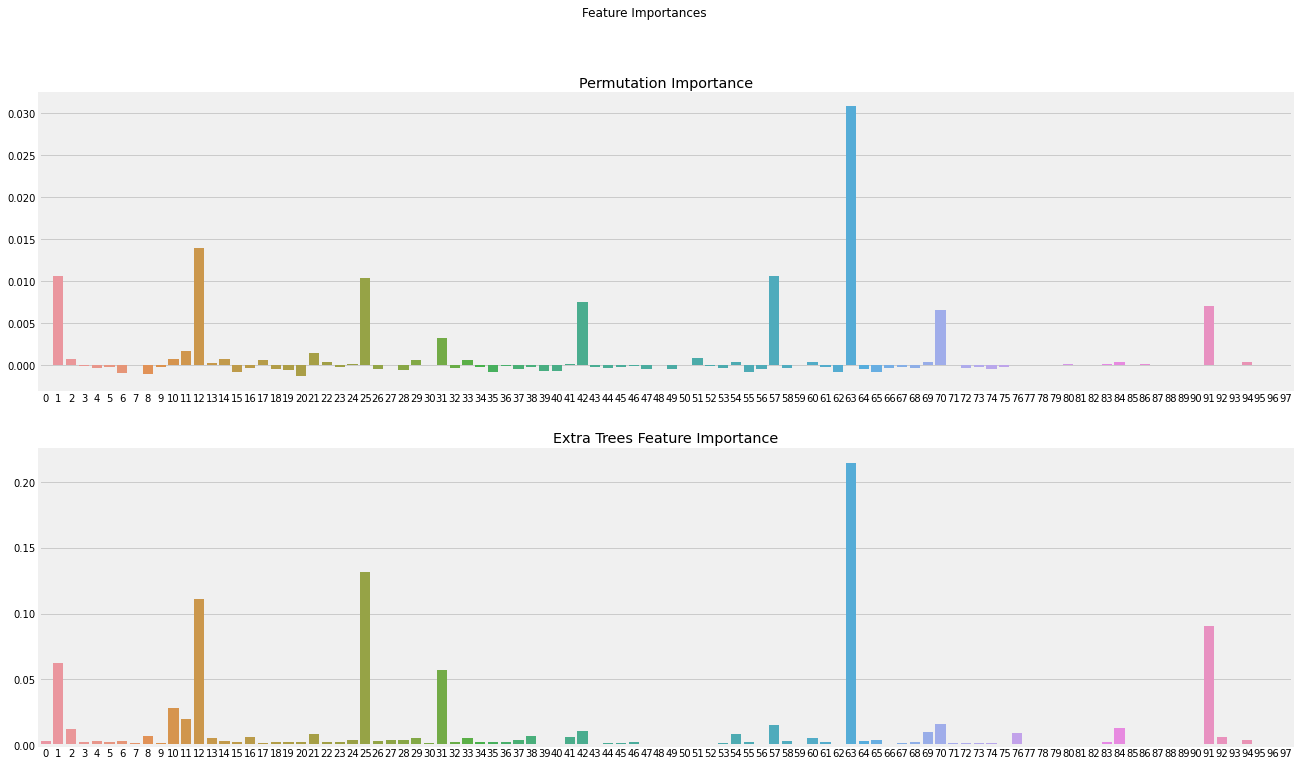

In [260]:
# calculate permutation importance
perm2 = permutation_importance(search2,
                             scoring='f1',X=Xval, y=yval,n_repeats=30,random_state=0)
importance2 = perm2.importances_mean

imp2 = search2.best_estimator_._final_estimator.feature_importances_

# plot permutation importance
fig, axs = plt.subplots(2,figsize=(20,12))
fig.suptitle('Feature Importances')
sns.barplot([x for x in range(98)], importance2[:98], ax=axs[0])
axs[0].set_title('Permutation Importance')
sns.barplot([x for x in range(len(imp))], imp2, ax = axs[1])
axs[1].set_title('Extra Trees Feature Importance')
plt.show()

Both Random Forest and Extremely Randomized Trees classifiers gave high importance to predictors Var126 (and it's counterpart nan_Var126), Var73 and Var7.



### Appetency and Upselling as target variables

In [47]:
binary

0       -1
1       -1
2       -1
3       -1
4       -1
        ..
49995    1
49996    1
49997   -1
49998   -1
49999   -1
Name: Appetency, Length: 50000, dtype: int64

In [48]:
# get target appetency values
y = y_appetency

In [49]:
X_train3, X_test3, y_train3, y_test3 = train_test_splitter(t,y)
Xtrain3, Xval3, ytrain3, yval3 = train_test_splitter(X_train3,y_train3)

In [50]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])
preprocessor = ColumnTransformer(
    transformers=[
        
        ('num', numeric_transformer, numerical_ix),
    ])

param = {'classifier__max_depth': [5,7], 
         'classifier__n_estimators':[50, 70, 100, 150], 
          'classifier__criterion' : ['gini', 'entropy'],
          'classifier__bootstrap':[True, False],
          'classifier__min_samples_leaf': [1,2,5]}

rf_clf = RandomForestClassifier( max_features='auto', 
                              
                                random_state=42,
                                class_weight='balanced_subsample')          

randomforestclf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('o',over),
                      ('classifier', rf_clf)],
              verbose=False)

searchapp = RandomizedSearchCV(randomforestclf,param_distributions=param,scoring='accuracy',cv=5)
searchapp.fit(Xtrain3, ytrain3)


In [51]:
# load the model
searchapp = joblib.load('../models/rforest/rf_appetency.pickle')
y_pred_test_app = searchapp.predict(X_test3)
print("The roc_auc_score of test data is:", np.round(roc_auc_score(y_test3,y_pred_test_app), 3))

The roc_auc_score of test data is: 0.643


In [52]:
# get target upselling values
y = y_upselling
# split data into train, test and validation
X_train4, X_test4, y_train4, y_test4 = train_test_splitter(t,y)
Xtrain4, Xval4, ytrain4, yval4 = train_test_splitter(X_train4,y_train4)

In [53]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])
preprocessor = ColumnTransformer(
    transformers=[
        
        ('num', numeric_transformer, numerical_ix),
    ])

param = {'classifier__max_depth': [5,7], 
         'classifier__n_estimators':[50, 70, 100, 150], 
          'classifier__criterion' : ['gini', 'entropy'],
          'classifier__bootstrap':[True, False],
          'classifier__min_samples_leaf': [1,2,5]}

rf_clf = RandomForestClassifier( max_features='auto', 
                              
                                random_state=42,
                                class_weight='balanced_subsample')          

randomforestclf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('o',over),
                      ('classifier', rf_clf)],
                       verbose=False)

searchup = RandomizedSearchCV(randomforestclf,param_distributions=param,scoring='accuracy',cv=5)
searchup.fit(Xtrain4, ytrain4)

In [54]:
# load model
searchup = joblib.load('../models/rforest/rf_upselling.pickle')
y_pred_test_up = searchup.predict(X_test4)
print("The roc_auc_score of test data is:", np.round(roc_auc_score(y_test4,y_pred_test_up), 3))

The roc_auc_score of test data is: 0.72


## Results

In [55]:
y_pred_val_rf_1 = searchapp.predict_proba(Xval3)[:,-1]
fpr_rf1, tpr_rf1, _ = roc_curve(yval3, y_pred_val_rf_1)
y_pred_val_rf_2 = searchup.predict_proba(Xval4)[:,-1]
fpr_rf2, tpr_rf2, _ = roc_curve(yval4, y_pred_val_rf_2)

target_aucs = [roc_auc_score(yval,y_predict_val_rf),roc_auc_score(yval3,y_pred_val_rf_1),roc_auc_score(yval4,y_pred_val_rf_2)]
summary = PrettyTable()
summary.field_names = ["Data","AUC score","Average AUC score"]
summary.add_row(["Churn",roc_auc_score(yval,y_predict_val_rf),' '])
summary.add_row(["Appetency",roc_auc_score(yval3,y_pred_val_rf_1),np.average(target_aucs)])
summary.add_row(["Up-selling",roc_auc_score(yval4,y_pred_val_rf_2),' '])
print(summary)

+------------+--------------------+--------------------+
|    Data    |     AUC score      | Average AUC score  |
+------------+--------------------+--------------------+
|   Churn    | 0.6273101898101898 |                    |
| Appetency  | 0.7208604621473254 | 0.7294778411196484 |
| Up-selling | 0.8402628714014304 |                    |
+------------+--------------------+--------------------+


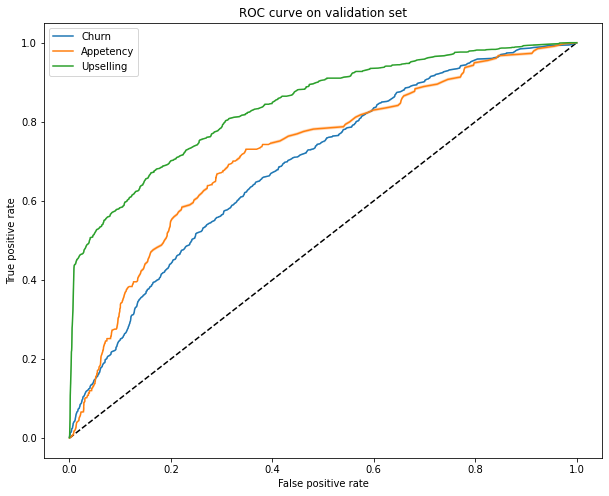

In [56]:
# plot
plt.figure(figsize=(10,8))
sns.lineplot([0, 1], [0, 1], linestyle='--',color='k')
sns.lineplot(fpr_rf, tpr_rf, label='Churn',)
sns.lineplot(fpr_rf1,tpr_rf1, label='Appetency')
sns.lineplot(fpr_rf2, tpr_rf2, label='Upselling')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve on validation set')
plt.legend(loc='best')
plt.show()

## Neural Network With Entity Embedding

In [57]:
# change plotting style
plt.style.use('fivethirtyeight')

In [58]:
# load the data (same data as above but target labels are already
# converted to 0's and 1's)
new_df = pd.read_pickle('../data/preprocessed_data.pickle')
new_df.head()

,Var6,Var7,Var13,Var21,Var24,Var25,Var28,Var35,Var38,Var44,...,nan_Var218,nan_Var219,nan_Var221,nan_Var223,nan_Var226,nan_Var227,nan_Var228,Appetency,Churn,Upselling
0,1526.000000,7.0,184.0,464.000000,14.000000,128.0,166.56,0.0,3570.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
1,525.000000,0.0,0.0,168.000000,2.000000,24.0,353.52,0.0,4764966.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
2,5236.000000,7.0,904.0,1212.000000,26.000000,816.0,220.08,0.0,5883894.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
3,69.125019,0.0,0.0,13.556917,0.361196,0.0,22.08,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
4,1029.000000,7.0,3216.0,64.000000,4.000000,64.0,200.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0


In [59]:
# get categorical columns
cat_df = new_df.select_dtypes(exclude=np.number)
cat_cols = cat_df.columns.tolist()

# get numerical columns
num_df = new_df.select_dtypes(include=np.number)

In [60]:
# create new df with categorical features at first
new_df = pd.concat([cat_df, num_df], axis=1)
new_df.shape

(50000, 123)

In [61]:
# get all target feature names
targets = ['Appetency', 'Churn', 'Upselling']

# separate target and features
X = new_df.drop(columns=targets)
y = new_df.Upselling

X.shape, y.shape

((50000, 120), (50000,))

In [62]:
# get only numerical columns (excluding binary features)
num_cols = ['Var6', 'Var7', 'Var13', 'Var21', 'Var24', 'Var25', 'Var28', 'Var35',
            'Var38', 'Var44', 'Var57', 'Var65', 'Var73', 'Var74', 'Var76', 'Var78',
            'Var81', 'Var83', 'Var85', 'Var109', 'Var112', 'Var113', 'Var119', 'Var123',
            'Var125', 'Var126', 'Var132', 'Var133', 'Var134', 'Var140', 'Var143', 'Var144',
            'Var149', 'Var153', 'Var160', 'Var163', 'Var173', 'Var181']

In [63]:
# label encode categorical features (first step before applying Entity Embedding)
les = {}

for col in cat_df.columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    les[col] = le

In [64]:
# verify the label encoding
X.head()

,Var192,Var193,Var195,Var196,Var197,Var203,Var204,Var205,Var206,Var207,...,nan_Var211,nan_Var212,nan_Var216,nan_Var218,nan_Var219,nan_Var221,nan_Var223,nan_Var226,nan_Var227,nan_Var228
0,225,25,22,0,177,0,28,1,11,10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,91,25,22,0,13,0,79,3,21,10,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,248,5,22,0,157,0,37,1,11,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,269,25,22,0,203,0,57,1,16,10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,131,25,22,0,209,0,43,3,3,10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [65]:
# define a function to preprocess input before feeding to the model
def split_features(X):
    X_list = []
    
    for i, col in enumerate(X.columns):
        x = X.iloc[:, i]
        X_list.append(x)

    return X_list

In [66]:
# split the data into train and validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [67]:
# create copy of X_train and X_val
X_train_sc = X_train.copy()
X_val_sc = X_val.copy()

# instantiate StandardScaler
sc = StandardScaler()
# scale numerical train data
X_train_sc[num_cols] = sc.fit_transform(X_train[num_cols])
# scale numerical validataion data
X_val_sc[num_cols] = sc.transform(X_val[num_cols])

In [69]:
# Create a Entity Embedding Model Architecture 

input_model = []
embeddings = []
for col in X.columns :
    if col in cat_cols:
        # get total unique values
        n_unique = X[col].nunique()
        # output dimension for EE
        n_dim = int(np.sqrt(n_unique))
        input_ = Input(shape=(1, ))
        output = Embedding(input_dim=n_unique, 
                                output_dim=n_dim, name=col)(input_)
        output = Reshape(target_shape=(n_dim, ))(output)
    else:
        input_ = Input(shape=(1, ))
        output = Dense(1)(input_)
    
    input_model.append(input_)
    embeddings.append(output)
# concatenate 
output_model = Concatenate()(embeddings)

#output model layers
output_model = Dense(800, kernel_initializer='he_normal', activation='relu')(output_model)
output_model = Dense(400, kernel_initializer='uniform', activation='relu')(output_model)
output_model = Dense(1, activation='sigmoid')(output_model)

# final model
model = keras.Model(inputs=input_model, outputs=output_model)

# display model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_121 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_122 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_123 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_124 (InputLayer)          [(None, 1)]          0                                            
______________________________________________________________________________________________

In [70]:
# compile the model
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0001), metrics=['AUC'])

In [220]:
# define early stopping callback
es = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

# train the model
history  =  model.fit( split_features(X_train_sc)  , y_train  , epochs =  100 , batch_size = 64, verbose= 1 ,
                      validation_data=(split_features(X_val_sc), y_val), callbacks=[es])

Epoch 1/100
625/625 [==============================] - 18s 17ms/step - loss: 0.2838 - auc: 0.6132 - val_loss: 0.2368 - val_auc: 0.7322
Epoch 2/100
625/625 [==============================] - 9s 14ms/step - loss: 0.2251 - auc: 0.7622 - val_loss: 0.2179 - val_auc: 0.7709
Epoch 3/100
625/625 [==============================] - 9s 14ms/step - loss: 0.2064 - auc: 0.8097 - val_loss: 0.2093 - val_auc: 0.7933
Epoch 4/100
625/625 [==============================] - 9s 14ms/step - loss: 0.1959 - auc: 0.8439 - val_loss: 0.2092 - val_auc: 0.7978
Epoch 5/100
625/625 [==============================] - 8s 14ms/step - loss: 0.1820 - auc: 0.8671 - val_loss: 0.2101 - val_auc: 0.8054
Epoch 6/100
625/625 [==============================] - 9s 14ms/step - loss: 0.1865 - auc: 0.8680 - val_loss: 0.2098 - val_auc: 0.8041
Epoch 7/100
625/625 [==============================] - 9s 14ms/step - loss: 0.1789 - auc: 0.8758 - val_loss: 0.2084 - val_auc: 0.8036
Epoch 8/100
625/625 [==============================] - 9s 14m

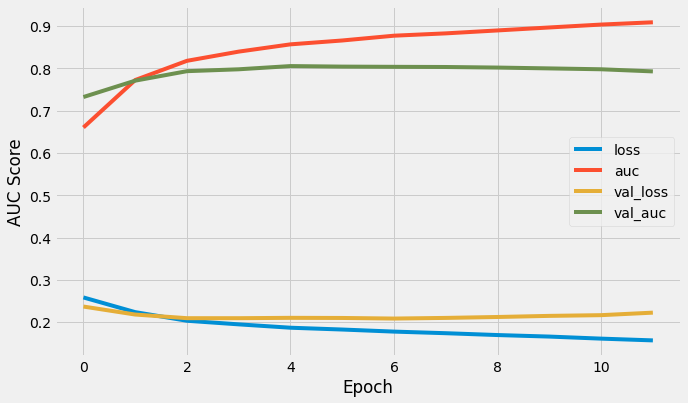

In [221]:
# plot the auc score and loss
fig, ax = plt.subplots(figsize=(10, 6))
pd.DataFrame(history.history).plot(ax=ax)
plt.xlabel('Epoch')
plt.ylabel('AUC Score')
plt.show()

In [222]:
# save the embeddings for future use
embedding_list = []

for col in cat_cols:
    emb = model.get_layer(col).get_weights()[0]
    embedding_list.append(emb)

with open('../data/embeddings.pickle', 'wb') as f:
    pickle.dump(embedding_list, f, -1)

In [71]:
#combining embedding
def embed_features(X, saved_embeddings_fname='../data/embeddings.pickle'):
    f_embeddings = open(saved_embeddings_fname, "rb")
    embeddings = pickle.load(f_embeddings)

    index_embedding_mapping = np.arange(len(cat_cols))
    X_embedded = []

    (num_records, num_features) = X.shape
    for record in X:
        embedded_features = []
        for i, feat in enumerate(record):
            feat = int(feat)
            if i not in index_embedding_mapping:
                embedded_features += [feat]
            else:
                embedding_index = i
                embedded_features += embeddings[embedding_index][feat].tolist()

        X_embedded.append(embedded_features)

    return np.array(X_embedded)

In [72]:
# create a helper function to split and scale the data
def split_scale(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    sc = StandardScaler()
    X_train_sc = X_train.copy()
    X_test_sc = X_test.copy()

    X_train_sc[num_cols] = sc.fit_transform(X_train_sc[num_cols])
    X_test_sc[num_cols] = sc.transform(X_test_sc[num_cols])
    
    return X_train_sc, X_test_sc, y_train, y_test

## Train and Evaluate NN on all Target Features

[INFO-1]Training model with Churn data...
[INFO-2]Training model with Appetency data...
[INFO-3]Training model with Upselling data...


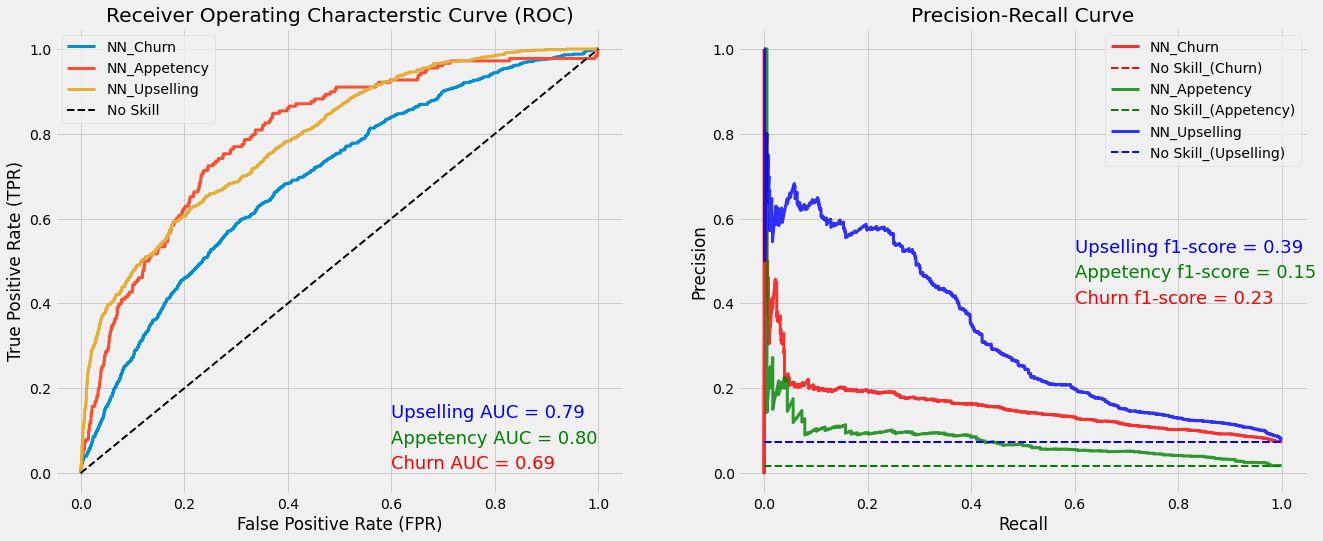

In [227]:
def train_and_evaluate_all(X, targets):
    # get predictors
    X_ = X.copy()
    
    # define list to add model history
    histories = []
    i = 0.01
    j = 0.4
    fig, ax = plt.subplots(1, 2, figsize=(20, 8))
    colors = ['red', 'green', 'blue']
    
    data = {}
    
    for ind, target in enumerate(targets):
        # store auc and f1
        temp = {}
        # get a target feature
        y = new_df[target]

        # get scaled train and test data
        X_train_sc, X_test_sc, y_train, y_test = split_scale(X_, y)
        # encode categories with Entity Embeddings
        X_train_sc = embed_features(X_train_sc.values)
        X_test_sc = embed_features(X_test_sc.values)

        # create a model architecture
        model = Sequential()
        model.add(Dense(300, activation='relu', input_shape=X_train_sc.shape[1:]))
        model.add(Dense(100, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        lr = 0.01
        # compile the model
        model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0001),
              metrics=['AUC'])
        # create early stopping callback
        early_stop = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
        # fit the model
        print(f'[INFO-{ind+1}]Training model with {target} data...')
        history = model.fit(X_train_sc, y_train, epochs=80, validation_data=(X_test_sc, y_test),
                    batch_size=32, callbacks=[early_stop], verbose=0)
        # store model history
        histories.append(history)
        
        # save the model to disk
        model.save(f'../models/nn_model_{target}.h5')
        
        # get prediction
        y_pred = model.predict(X_test_sc)
        # get fpr, tpr and thresholds
        fpr, tpr, thres = roc_curve(y_test, y_pred)
        # calculate AUC Score
        auc_score = roc_auc_score(y_test, y_pred) 


        ax[0].plot(fpr, tpr, label=f'NN_{target}', linewidth=3)
        
        ax[0].set_xlabel('False Positive Rate (FPR)')
        ax[0].set_ylabel('True Positive Rate (TPR)')
        ax[0].set_title('Receiver Operating Characterstic Curve (ROC)')
        ax[0].text(0.6, i, f'{target} AUC = {auc_score:.2f}', fontsize=18, color=colors[ind])
        
        # get precision, recall and thresholds
        precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
        # convert to f-measure
        fscore = (2 * precision * recall) / ((precision + recall))
        # locate the index of the largest f-measure
        max_f1 = max(fscore)
        no_skill = len(y_test[y_test==1]) / len(y_test)
        ax[1].plot(recall, precision, label=f'NN_{target}', color=colors[ind], alpha=0.8, linewidth=3)
        ax[1].set_xlabel('Recall')
        ax[1].set_ylabel('Precision')
        ax[1].set_title('Precision-Recall Curve')
        ax[1].text(0.6, j, f'{target} f1-score = {max_f1:.2f}', fontsize=18, color=colors[ind])
        ax[1].plot([0, 1],[no_skill, no_skill], linestyle='--', label=f'No Skill_({target})',
                   color=colors[ind], linewidth=2)
        i += 0.06
        j += 0.06
        
        # store f1 and auc
        temp['AUC'] = np.round(auc_score, 3)
        temp['F1-Score'] = np.round(max_f1, 3)
        # add temp to main dictionary
        data[target] = temp
    
    ax[0].plot([0, 1], [0, 1], '--', label='No Skill', color='black', linewidth=2)
    ax[0].legend()
    ax[1].legend()
    plt.show()
    
    return pd.DataFrame(data).transpose(), histories

        
targets = ['Churn', 'Appetency', 'Upselling']
# call the function to train and evaluate the model on three different targets
data, histories = train_and_evaluate_all(X, targets)

In [280]:
data

,AUC,F1-Score
Churn,0.693,0.234
Appetency,0.798,0.149
Upselling,0.791,0.392
